In [228]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid

In [229]:
# define evaluation metrics for volatility forecasting
def rmse_var(y_true, y_pred, is_vol=False):
    if is_vol:
        y_true = np.square(y_true)
        y_pred = np.square(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


def qlike_var(y_true, y_pred, is_vol=False, eps=1e-12):
    if is_vol:
        y_true = np.square(y_true)
        y_pred = np.square(y_pred)
    ratio = (y_true + eps) / (y_pred + eps)
    return float(np.mean(ratio - np.log(ratio) - 1.0))


### Building XGBoost

In [230]:
btc_df = pd.read_csv('../Data/btc_final_df.csv')

In [231]:
def rolling_time_series_cv(df, n_splits=5):
    df = df.sort_values('timestamp').reset_index(drop=True)
    n = len(df)
    train_end = int(0.70 * n)
    val_end = int(0.85 * n)
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    train_size = len(train_df)
    step = train_size // n_splits
    splits = []

    for i in range(n_splits):
        start = i * step
        end = start + step
        if end > train_size:
            break
        train_idx = np.arange(start, end)
        test_idx = np.arange(end, min(end + step, train_size))
        if len(test_idx) > 0:
            splits.append((train_idx, test_idx))

    return splits, val_df, test_df


In [232]:
def split_train_val_test(df, train_ratio=0.7, val_ratio=0.15):
    df = df.sort_values('timestamp').reset_index(drop=True)
    n = len(df)

    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    train_df = df.iloc[:train_end].copy()
    val_df = df.iloc[train_end:val_end].copy()
    test_df = df.iloc[val_end:].copy()

    print(f"Train samples: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)


In [233]:
def train_base_model(train_df, features, target='vol_future', params=None, n_splits=5):
    print("\nTraining base model with rolling cross-validation on 70% training data...")

    splits, _, _ = rolling_time_series_cv(train_df, n_splits=n_splits)
    fold_models = []
    fold_scores = []

    for i, (train_idx, val_idx) in enumerate(splits):
        X_train, y_train = train_df.iloc[train_idx][features], train_df.iloc[train_idx][target]
        X_val, y_val = train_df.iloc[val_idx][features], train_df.iloc[val_idx][target]

        model = XGBRegressor(**(params or {}))
        model.fit(X_train, y_train, verbose=False)
        y_pred = model.predict(X_val)
        score = rmse_var(y_val, y_pred, is_vol=True)
        fold_models.append(model)
        fold_scores.append(score)
        print(f"Fold {i+1}: RMSE = {score:.6f}")

    avg_score = np.mean(fold_scores)
    print(f"\nAverage rolling CV RMSE: {avg_score:.6f}")

    # retrain final model on full training set
    final_model = XGBRegressor(**(params or {}))
    final_model.fit(train_df[features], train_df[target], verbose=False)
    return final_model


In [234]:
def tune_model(train_model, val_df, features, target='vol_future', param_grid=None):
    print("\nTuning hyperparameters on validation set (single 15% set)...")

    if param_grid is None:
        param_grid = {
            'max_depth': [2, 3, 5],
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [200, 400],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }

    X_val, y_val = val_df[features].values, val_df[target].values
    best_score = np.inf
    best_params = None
    results = []

    for params in ParameterGrid(param_grid):
        model = XGBRegressor(random_state=42, n_jobs=-1, **params)
        model.fit(X_val, y_val, verbose=False)
        y_pred = model.predict(X_val)
        score = rmse_var(y_val, y_pred, is_vol=True)
        results.append({'params': params, 'score': score})
        if score < best_score:
            best_score = score
            best_params = params

    results_df = pd.DataFrame(results).sort_values('score').reset_index(drop=True)
    print("Best tuned parameters:", best_params)
    print(f"Best validation RMSE: {best_score:.6f}")
    return best_params, results_df


In [235]:
def train_and_test(df, features, target='vol_future', param_grid=None):
    # 1) split
    train_df, val_df, test_df = split_train_val_test(df)

    # 2) Train 
    base_model = train_base_model(train_df, features, target)

    # 3) Tune hyperparameters on validation set (5-fold rolling CV)
    best_params, results_df = tune_model(base_model, val_df, features, target, param_grid)

    # 4) Retrain final model on 70% training data with best parameters
    print("\nRetraining final model on 70% training data with tuned parameters")
    X_train, y_train = train_df[features], train_df[target]
    model = XGBRegressor(**best_params)
    model.fit(X_train, y_train, verbose=False)

    # 5) Evaluate once on last 15% (test set)
    print("\nEvaluating on the test set (last 15%)")
    X_test, y_test = test_df[features], test_df[target]
    y_pred = model.predict(X_test)

    ql = qlike_var(y_test, y_pred, is_vol=True)
    rm = rmse_var(y_test, y_pred, is_vol=True)
    print(f"Test Results — QLIKE: {ql:.6f}, RMSE: {rm:.6f}")

    # 6) Store predictions
    predictions_df = test_df[['timestamp', target]].copy()
    predictions_df['pred_vol_future'] = y_pred

    return model, best_params, results_df, predictions_df


In [236]:
# Ensure timestamp is datetime
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])

# Feature columns
features = [c for c in btc_df.columns if c not in ['timestamp', 'vol_future']]

# Train, tune, and test
model, best_params, cv_results, predictions_df = train_and_test(btc_df, features)

Train samples: 5745, Val: 1231, Test: 1232

Training base model with rolling cross-validation on 70% training data...
Fold 1: RMSE = 3.222855
Fold 2: RMSE = 3.905177
Fold 3: RMSE = 3.977650
Fold 4: RMSE = 5.232294
Fold 5: RMSE = 5.279531

Average rolling CV RMSE: 4.323501

Tuning hyperparameters on validation set (single 15% set)...
Best tuned parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.8}
Best validation RMSE: 0.176491

Retraining final model on 70% training data with tuned parameters

Evaluating on the test set (last 15%)
Test Results — QLIKE: 0.019219, RMSE: 6.703050


### Plotting of results and Feature importance

In [237]:
## importing libraries
import matplotlib.pyplot as plt


In [238]:

def plot_predicted_vs_actual(predictions_df, title="Predicted vs Actual Volatility (Test Set)"):
    """
    Plot predicted vs actual volatility for the test set.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(predictions_df['timestamp'], predictions_df['vol_future'], label='Actual Volatility', linewidth=2)
    plt.plot(predictions_df['timestamp'], predictions_df['pred_vol_future'], label='Predicted Volatility', linewidth=2, linestyle='--')
    
    plt.title(title, fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Volatility", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


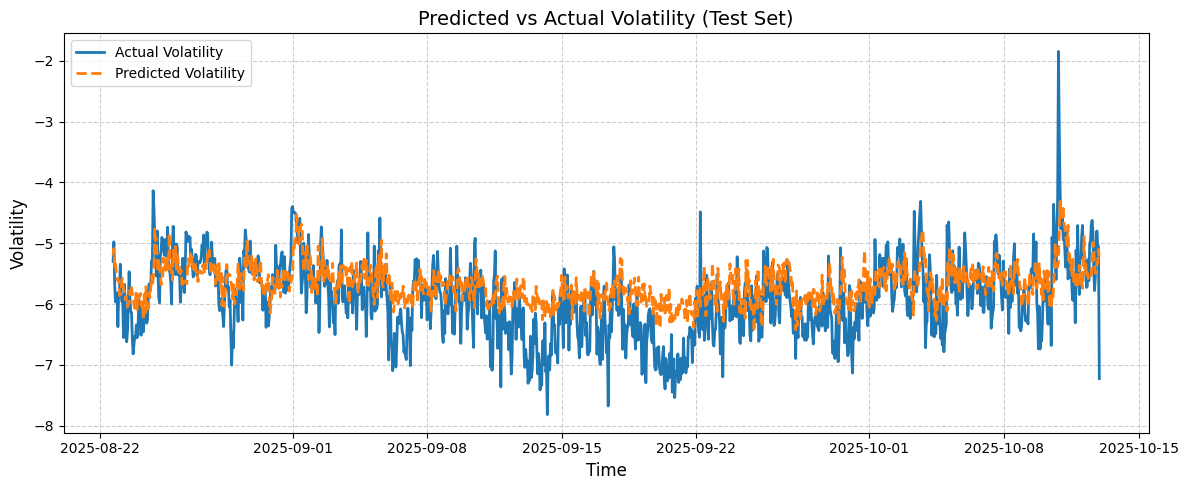

In [239]:
# Plot results
plot_predicted_vs_actual(predictions_df)


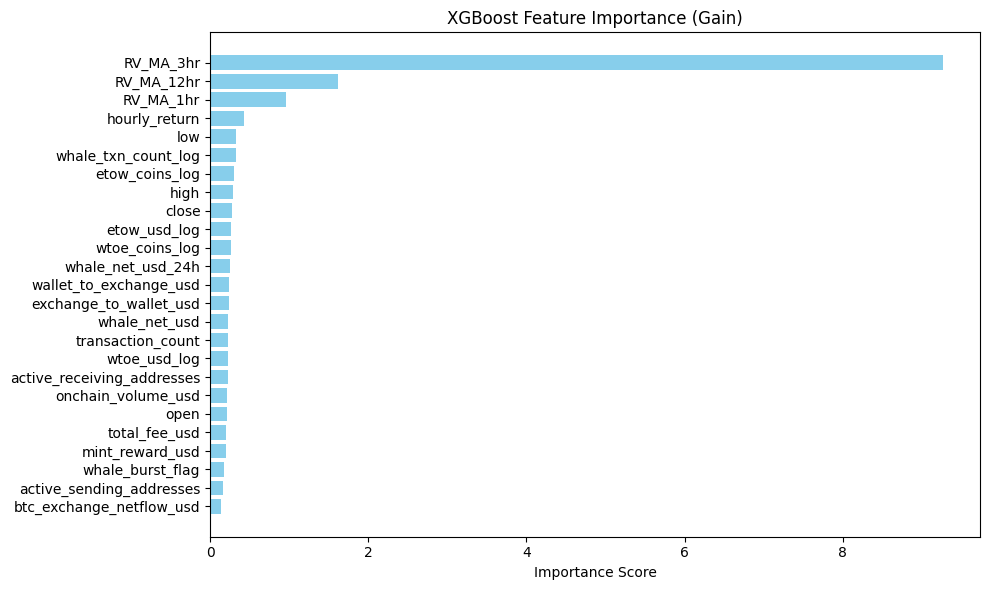

In [240]:
importance = model.get_booster().get_score(importance_type='gain')
importance_df = (
    pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
    .sort_values('Importance', ascending=True)
)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title("XGBoost Feature Importance (Gain)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [241]:
predictions_df.to_csv('../Results/btc_xgb_prediction.csv', index=False)